In [18]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
plt.rcParams['figure.figsize'] = [20, 10]

In [21]:
lines = np.array([[424, 118, 425, 191],
       [474, 472, 542, 511],
       [204, 317, 266, 281],
       [530, 552, 570, 572],
       [537, 128, 596,  96],
       [154, 409, 219, 371],
       [592,  96, 662, 136],
       [328, 308, 372, 284],
       [205, 379, 238, 396],
       [149, 287, 218, 326],
       [118, 376,  58, 394],
       [302, 373, 353, 398],
       [441, 507, 374, 469],
       [432, 558, 487, 590],
       [370, 286, 371, 221],
       [484, 467, 541, 497],
       [ 99, 332, 163, 292],
       [112, 324,  56, 303],
       [759, 194, 762, 126],
       [648, 192, 702, 223],
       [371, 222, 425, 192],
       [486, 590, 545, 559],
       [100, 376, 153, 409],
       [647, 128, 708,  96],
       [152, 287,  97, 317],
       [762, 142, 693, 102],
       [434, 563, 430, 498],
       [703,  96, 763, 128],
       [273, 402, 320, 380],
       [647, 126, 649, 192],
       [102, 381,  98, 316],
       [660, 201, 661, 122],
       [208, 381, 204, 315],
       [432, 499, 483, 468],
       [761, 191, 700, 223],
       [691, 218, 760, 180],
       [542, 560, 540, 496],
       [446, 570, 440, 493],
       [215, 310, 218, 386],
       [273, 390, 316, 367],
       [362, 110, 388, 111],
       [387,  97, 434, 123],
       [165, 405, 100, 367],
       [418, 130, 461, 106],
       [474, 584, 543, 546],
       [425, 133, 383, 110],
       [746, 186, 791, 212],
       [376, 471, 375, 434],
       [251, 281, 292, 304],
       [759, 127, 797, 109],
       [266, 289, 265, 247],
       [316, 340, 315, 381],
       [253, 249, 251, 289],
       [  8, 348,  23, 326],
       [  8, 350,  25, 372]], dtype=np.int32)
letters_txt = np.array([
    [45, 300, 'O'],
    [45, 400, 'O'],
    [260, 235, 'O'],
    [260, 400, 'N'],
    [313, 320, 'N'],
    [370, 410, 'S'],
    [590, 580, 'Cl'],
    [370, 100, 'O'],
    [485, 100, 'NH'],
    [805, 100, 'O'],
    [805, 220, 'O']
], dtype=object)

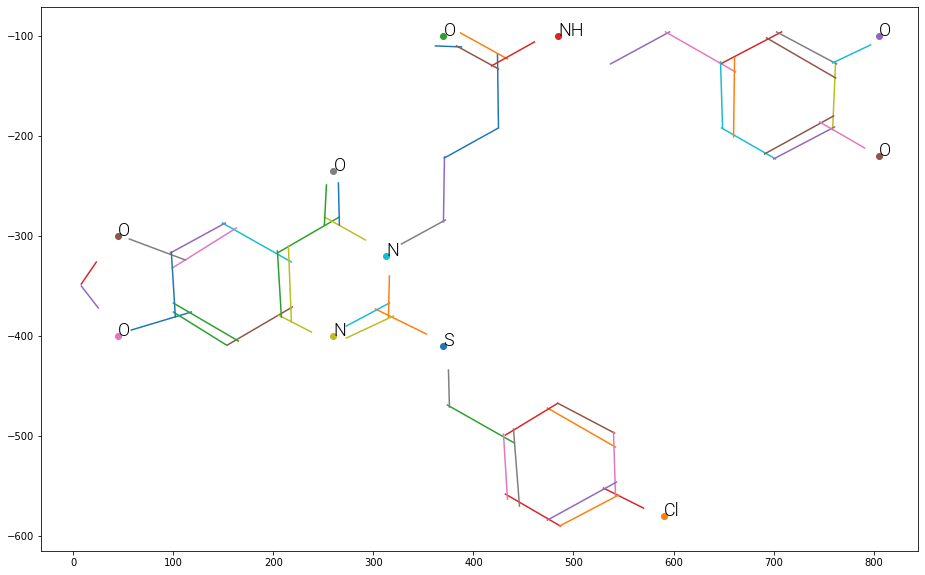

In [54]:
plt.gca().set_aspect('equal', adjustable='box')

#line_mean = np.sqrt((lines[0] - lines[2]) ** 2 + (lines[1] - lines[3]) ** 2).mean()
points = []
complement = dict()
for line in lines:
    x1, y1, x2, y2 = line
    p1 = np.array((x1, y1))
    p2 = np.array((x2, y2))
    points.append(p1)
    points.append(p2)
    complement[tuple(p1)] = p2
    complement[tuple(p2)] = p1
    plt.plot([x1, x2], [-y1, -y2])


for let in letters_txt:
    plt.plot(let[0], -let[1], 'o')
    plt.annotate(let[2], (let[0], -let[1]), fontsize=18, fontfamily='Roboto', fontweight='light')

letters = np.array([np.array([let[0], let[1]], dtype=np.int32) for let in letters_txt])
plt.show()

In [192]:
all_points = np.concatenate((points, letters))
n_pts = len(all_points)
letters_set = set([tuple(l) for l in letters.tolist()])

all_points = all_points.tolist()
inf = np.float64(1e9)

def dist(p1, p2):
    return np.sqrt((p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2)

def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    if div == 0:
       raise Exception('lines do not intersect')

    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

middles = [
    ((i[0] + i[2]) / 2, (i[1] + i[3]) / 2) for i in lines
]


distances = np.zeros((n_pts, n_pts), dtype=np.float64)
for i in range(n_pts):
    for j in range(i + 1, n_pts):
        distances[i][j] = inf
        pt1 = tuple(all_points[i])
        pt2 = tuple(all_points[j])
        if pt1 in letters_set and pt2 in letters_set:
            distances[i][j] = inf
        elif pt1 in letters_set:
            c = complement[pt2]
            if dist(pt1, pt2) > dist(pt1, c):
                distances[i][j] = inf
            else:
                distances[i][j] = dist(pt1, pt2) / 2
        elif pt2 in letters_set:
            c = complement[pt1]
            if dist(pt1, pt2) > dist(pt2, c):
                distances[i][j] = inf
            else:
                distances[i][j] = dist(pt1, pt2)
                
        else:
            c1 = complement[pt1]
            c2 = complement[pt2]
            if dist(pt1, pt2) > dist(pt1, c2) or dist(pt1, pt2) > dist(c1, pt2):
                distances[i][j] = inf
            else:
                distances[i][j] = dist(pt1, pt2)
                try:
                    x, y = line_intersection((pt1, c1), (pt2, c2))
                    dmin = min(dist((x, y), pt1), dist((x, y), pt2))
                    filter_ = lambda p: (p[0] != pt1[0] or p[1] != pt1[1]) and (p[0] != pt2[0] or p[1] != pt2[1])
                    if all(dist((x, y), mid) > dmin for mid in middles + points if filter_(mid)):
                        #print(f'cropped: {i} {j}')
                        distances[i][j] *= 0.7
                except Exception:
                    pass
            
        distances[j][i] = distances[i][j]

distances[distances < inf].mean()

282.36261803872105

In [193]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import pairwise_distances

In [201]:
#metric = pairwise_distances(distances, metric='precomputed')

cluster = DBSCAN(eps=30, min_samples=1, metric='precomputed')
core_samples_range = range(len(points), len(all_points))

cluster.core_sample_indices_ = np.array(core_samples_range)
labels = cluster.fit(distances).labels_
labels

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  9, 12, 13, 14, 11,
       15, 16,  4, 17, 18, 19, 20, 21, 22, 23, 24, 14, 25,  2,  3, 26, 16,
       26, 27, 28, 29, 30, 31, 25,  1, 24,  6, 17, 10, 12, 32, 16, 26, 29,
       32, 23, 21, 32, 29, 15, 19, 12, 30, 17, 26, 30, 12, 11,  4, 21,  2,
       28, 31, 31, 28,  6,  3, 23, 21,  4, 11, 15, 19,  0,  0,  0,  0, 10,
       17,  0, 33, 24,  6,  0,  0, 28, 34, 22, 20,  5, 13, 29, 35,  5, 36,
       13, 19, 36,  5, 37, 27, 37, 18, 27, 18, 36, 15, 13, 20,  7,  0, 33,
       35, 34])

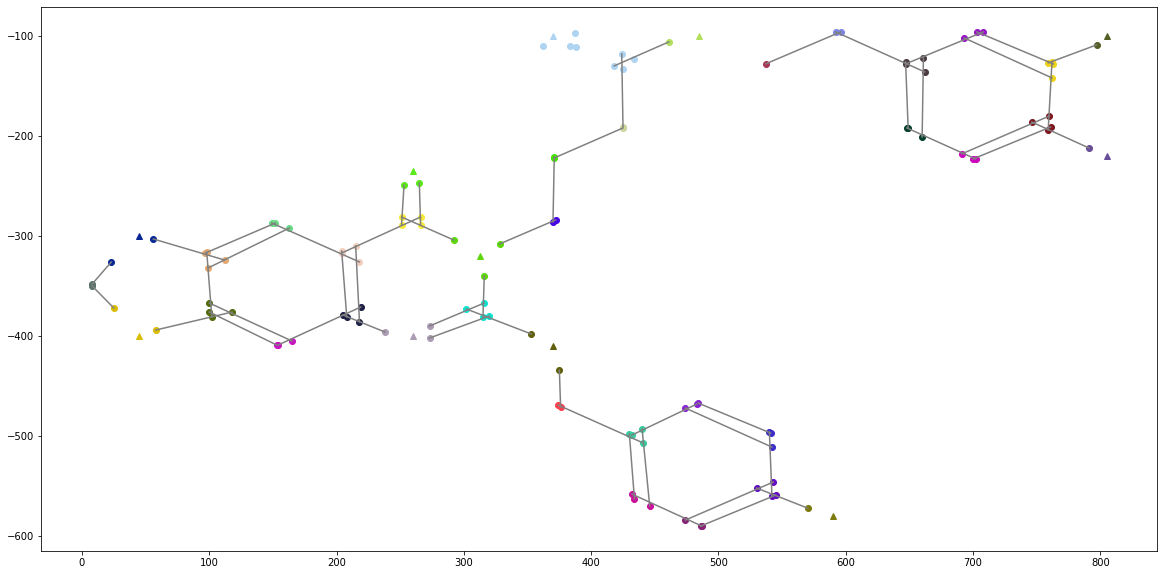

In [202]:
getcol = lambda x: (x + 1) / (len(cluster.labels_) + 1)

cols = {i: [np.random.random() for _ in range(3)] for i in range(-1, max(cluster.labels_) + 1)}

for i in range(len(all_points)):
    x, y = all_points[i]
    sty = 'o' if i not in core_samples_range else '^'
    plt.plot(x, -y, sty, color=cols[labels[i]])

for line in lines:
    x1, y1, x2, y2 = line
    p1i = all_points.index([x1, y1])
    p2i = all_points.index([x2, y2])
    if labels[p1i] != labels[p2i]:
        plt.plot([x1, x2], [-y1, -y2], color='gray')

ValueError: not enough values to unpack (expected 2, got 1)

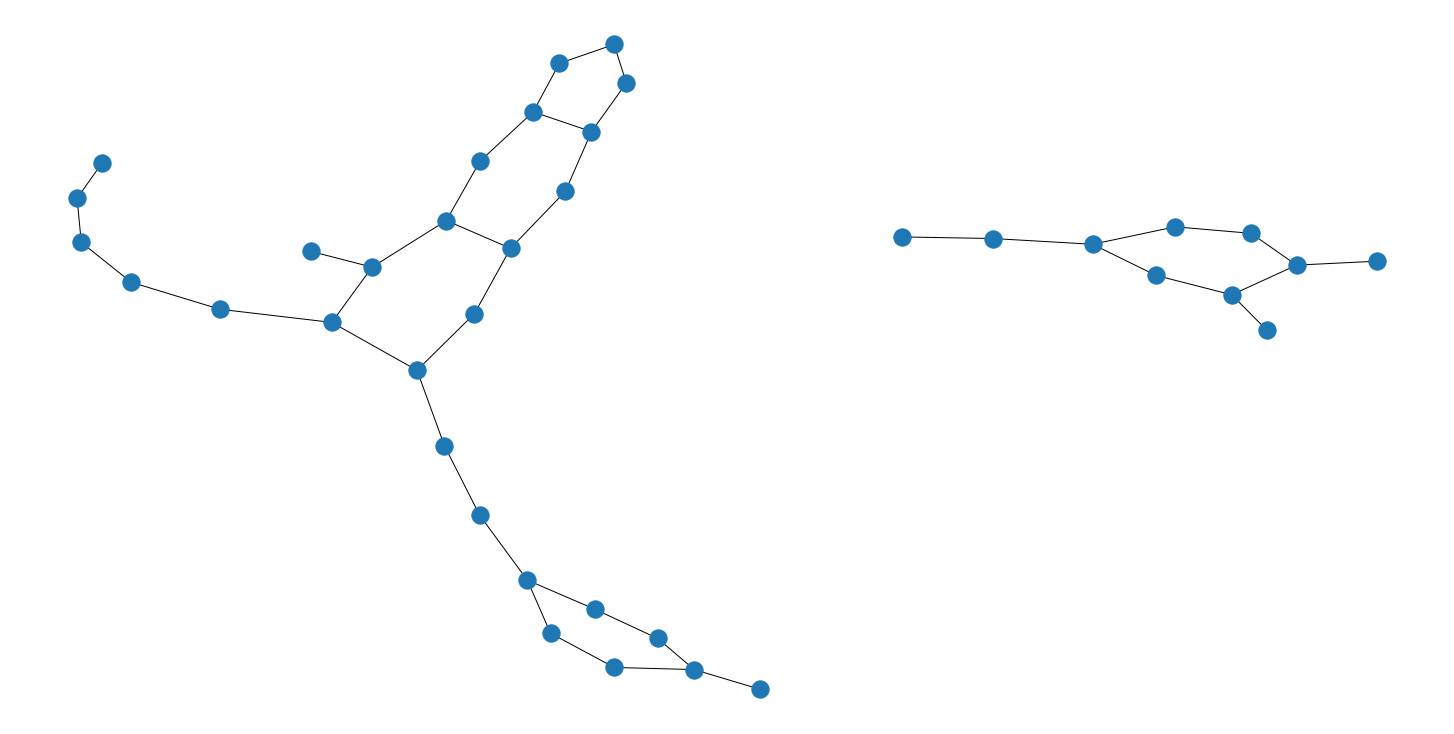

In [206]:
from collections import namedtuple
from pysmiles import write_smiles, fill_valence
import networkx as nx
import re

total_labels = np.max(cluster.labels_) + 1

mol = nx.Graph()
mol.add_nodes_from(range(total_labels))

edges = []
assert len(points) % 2 == 0

for i in range(len(points) // 2):
    node1 = labels[2 * i]
    node2 = labels[2 * i + 1]
    edge = (node1, node2)
    if edge in mol.edges():
        mol.edges[edge]['order'] = mol.edges[edge]['order'] + 1
    else:
        mol.add_edge(*edge, order=1)

for let, label_idx in zip(letters_txt, core_samples_range):
    lbl = labels[label_idx]
    elems_str = let[2]
    elems = re.findall(r'[A-Z][a-z0-9\+]*', elems_str)
    if len(elems) > 2:
        print('WARN: elems size > 2. may omit some values (elems: %s)' % elems)

    hcount = elems.count('H')
    elems = [e for e in elems if e != 'H']

    mol.nodes[lbl]['element'] = elems[0]
    #mol.nodes[lbl]['hcount'] = hcount
    
for node in mol.nodes():
    if 'element' not in mol.nodes[node]:
        mol.nodes[node]['element'] = 'C'


#for i, pt in enumerate(points):
nx.draw(mol)
for n 
#fill_valence(mol, respect_hcount=True)
write_smiles(mol)

In [252]:
[mol.edges[e] for e in mol.edges()], [mol.nodes[n] for n in mol.nodes()]

([{'order': 4},
  {'order': 1},
  {'order': 2},
  {'order': 1},
  {'order': 2},
  {'order': 2},
  {'order': 1},
  {'order': 2},
  {'order': 1},
  {'order': 1},
  {'order': 2},
  {'order': 2},
  {'order': 1},
  {'order': 1},
  {'order': 2},
  {'order': 1},
  {'order': 2},
  {'order': 3},
  {'order': 1},
  {'order': 2},
  {'order': 1},
  {'order': 2},
  {'order': 1},
  {'order': 1},
  {'order': 1}],
 [{'element': 'O'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'O'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'},
  {'element': 'C'}])